In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터 불러오기
data = pd.read_csv("data_data.csv")
# 데이터를 '지역'과 'Year' 기준으로 오름차순으로 정렬
data_sorted = data.sort_values(by=['Year', '지역'])

# 'Year' 열을 기준으로 정렬한 후 데이터를 다시 인덱스로 초기화
data_sorted.reset_index(drop=True, inplace=True)

# 훈련 데이터와 테스트 데이터의 분할 인덱스 계산
split_year = 2018  # 분할 기준 연도
train_indices = data_sorted[data_sorted['Year'] <= split_year].index
test_indices = data_sorted[data_sorted['Year'] > split_year].index

# 입력 데이터와 출력 데이터 분리
X = data_sorted[['강수량', '수위', '유입량']].copy()  # 데이터를 복사합니다.
X['수위'] = X['수위'] / 12  # '수위' 열의 값을 12로 나누어 수정합니다.
X = X.values  # 수정된 데이터를 다시 NumPy 배열로 변환합니다.

y = data_sorted[['발전량']].values

# 데이터를 훈련 데이터와 테스트 데이터로 나눔
X_train_one = X[train_indices]
X_test_one = X[test_indices]
y_train_one = y[train_indices]
y_test_one = y[test_indices]


In [2]:
# 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_one)
X_test = scaler_X.transform(X_test_one)
y_train = scaler_y.fit_transform(y_train_one)
y_test = scaler_y.transform(y_test_one)

In [3]:
# X_train과 X_test를 3차원으로 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [4]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [5]:
model.fit(X_train, y_train, epochs=700, batch_size=32, verbose=2)

Epoch 1/700
7/7 - 1s - loss: 0.0615 - 1s/epoch - 161ms/step
Epoch 2/700
7/7 - 0s - loss: 0.0514 - 16ms/epoch - 2ms/step
Epoch 3/700
7/7 - 0s - loss: 0.0438 - 15ms/epoch - 2ms/step
Epoch 4/700
7/7 - 0s - loss: 0.0382 - 14ms/epoch - 2ms/step
Epoch 5/700
7/7 - 0s - loss: 0.0340 - 16ms/epoch - 2ms/step
Epoch 6/700
7/7 - 0s - loss: 0.0320 - 21ms/epoch - 3ms/step
Epoch 7/700
7/7 - 0s - loss: 0.0315 - 20ms/epoch - 3ms/step
Epoch 8/700
7/7 - 0s - loss: 0.0316 - 14ms/epoch - 2ms/step
Epoch 9/700
7/7 - 0s - loss: 0.0314 - 13ms/epoch - 2ms/step
Epoch 10/700
7/7 - 0s - loss: 0.0310 - 13ms/epoch - 2ms/step
Epoch 11/700
7/7 - 0s - loss: 0.0308 - 14ms/epoch - 2ms/step
Epoch 12/700
7/7 - 0s - loss: 0.0307 - 14ms/epoch - 2ms/step
Epoch 13/700
7/7 - 0s - loss: 0.0305 - 15ms/epoch - 2ms/step
Epoch 14/700
7/7 - 0s - loss: 0.0304 - 14ms/epoch - 2ms/step
Epoch 15/700
7/7 - 0s - loss: 0.0303 - 13ms/epoch - 2ms/step
Epoch 16/700
7/7 - 0s - loss: 0.0301 - 13ms/epoch - 2ms/step
Epoch 17/700
7/7 - 0s - loss: 0.0

In [6]:
# 저장된 값 불러오기
from tensorflow.keras.models import load_model
model = load_model("full_model.h5")
model.load_weights("model_weights.h5")
model.compile(optimizer='adam', loss='mse')

In [7]:
# 테스트 데이터를 이용하여 예측
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 3ms/step


In [8]:
# 예측 결과를 역정규화하여 실제 값으로 변환
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

In [9]:
# 정렬된 테스트 데이터 인덱스
sorted_test_indices = sorted(test_indices)

for i, index in enumerate(sorted_test_indices):
    year = data_sorted.loc[index, 'Year']
    region = data_sorted.loc[index, '지역']
    rainfall = data_sorted.loc[index, '강수량']
    energy = data_sorted.loc[index, '발전량']
    
    # 수정된 부분: 정규화된 데이터로 훈련한 스케일러를 사용하여 역정규화합니다.
    actual = y_test_one[i][0]
    predicted_generation = y_pred_actual[i][0]  # 역정규화된 예측 값

    print(f"지역: {region}, 년도: {year}, 강수량: {rainfall}, 실제 발전량: {actual}, 예측 발전량: {predicted_generation}")

지역: 대청, 년도: 2019, 강수량: 984.2, 실제 발전량: 110521.5252, 예측 발전량: 79374.6484375
지역: 섬진강, 년도: 2019, 강수량: 1069.7, 실제 발전량: 75802.3, 예측 발전량: 96762.921875
지역: 소양강, 년도: 2019, 강수량: 791.0, 실제 발전량: 352275.6743, 예측 발전량: 228393.984375
지역: 안동, 년도: 2019, 강수량: 867.8, 실제 발전량: 104368.9672, 예측 발전량: 89164.6640625
지역: 용담, 년도: 2019, 강수량: 1338.0, 실제 발전량: 105366.328, 예측 발전량: 27216.376953125
지역: 의암, 년도: 2019, 강수량: 1481.6, 실제 발전량: 97223.0, 예측 발전량: 137529.921875
지역: 임하, 년도: 2019, 강수량: 867.8, 실제 발전량: 41020.4, 예측 발전량: 63208.86328125
지역: 주암, 년도: 2019, 강수량: 1461.0, 실제 발전량: 58782.90097, 예측 발전량: 29384.56640625
지역: 청평, 년도: 2019, 강수량: 931.0, 실제 발전량: 194857.0, 예측 발전량: 147459.125
지역: 춘천, 년도: 2019, 강수량: 923.2, 실제 발전량: 73524.0, 예측 발전량: 42775.1953125
지역: 충주, 년도: 2019, 강수량: 795.5, 실제 발전량: 494974.9064, 예측 발전량: 406465.375
지역: 합천, 년도: 2019, 강수량: 1417.6, 실제 발전량: 119498.1175, 예측 발전량: 92171.8828125
지역: 화천, 년도: 2019, 강수량: 920.5, 실제 발전량: 118538.0, 예측 발전량: 124113.390625
지역: 대청, 년도: 2020, 강수량: 1614.0, 실제 발전량: 201457.008, 예측 발전량: 153175.9687

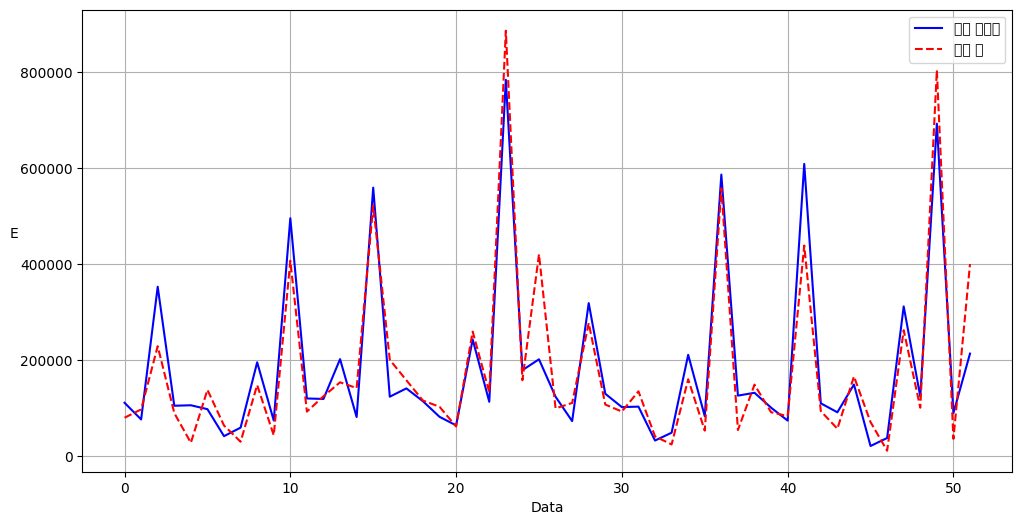

In [19]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
# 테스트 데이터 인덱스를 이용하여 실제 발전량과 예측 발전량 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='original', color='blue')
plt.plot(y_pred_actual,  label='prediction', color='red', linestyle='dashed')
plt.xlabel('Data')
plt.ylabel('E', rotation=0)
plt.title('')
plt.legend()
plt.grid()
plt.show()
 

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"훈련 세트 MAE: {train_mae:.4f}")
print(f"테스트 세트 MAE: {test_mae:.4f}")
print(f"훈련 세트 MSE: {train_mse:.4f}")
print(f"테스트 세트 MSE: {test_mse:.4f}")
print(f"훈련 세트 R2 점수: {train_r2:.4f}")
print(f"테스트 세트 R2 점수: {test_r2:.4f}")

2/2 [==============================] - 0s 2ms/step
훈련 세트 MAE: 0.0404
테스트 세트 MAE: 0.0400
훈련 세트 MSE: 0.0039
테스트 세트 MSE: 0.0032
훈련 세트 R2 점수: 0.8818
테스트 세트 R2 점수: 0.8658


In [12]:
# model.save("full_model.h5")
# model.save_weights("model_weights.h5")